In [1]:

RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages and repo if in colab
    !pip install ipywidgets &> /dev/null
    !pip install neuron &> /dev/null

    !git clone https://github.com/GregGlickert/Neural-Modeling-Manual.git &> /dev/null
    %cd Neural-Modeling-Manual/Chapter-2-Single-cells/Section-X-Build-A-Neuron/

from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import HBox,VBox
import os

if(os.path.exists('x86_64')==False):
    os.system('nrnivmodl') # compile modfiles. Return 0 for success, 1 for failure.

# Load NEURON standard run library
h.load_file('stdrun.hoc')
h.nrn_load_dll('x86_64/.libs/libnrnmech.so')

/Users/gregglickert/opt/anaconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/gregglickert/Documents/GitHub/Network-Modeling-Manual/Chapter-2-Single-cells/Section-X-Build-A-Neuron
Mod files: "./kdr.mod" "./leak.mod" "./na.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../kdr.mod
 -> NMODL ../na.mod
 -> NMODL ../leak.mod
 -> Compiling leak.c
 -> Compiling na.c
 -> Compiling kdr.c


Translating leak.mod into /Users/gregglickert/Documents/GitHub/Network-Modeling-Manual/Chapter-2-Single-cells/Section-X-Build-A-Neuron/x86_64/leak.c
Translating kdr.mod into /Users/gregglickert/Documents/GitHub/Network-Modeling-Manual/Chapter-2-Single-cells/Section-X-Build-A-Neuron/x86_64/kdr.c
Translating na.mod into /Users/gregglickert/Documents/GitHub/Network-Modeling-Manual/Chapter-2-Single-cells/Section-X-Build-A-Neuron/x86_64/na.c
Thread Safe
Thread Safe
Thread Safe
leak.c:na.c41::kdr.c18::43 warning: :4318a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
:: 18warning: : a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]warning: 
a function declaration without a prototype is deprecated 

 => LINKING shared library ./libnrnmech.dylib
 => LINKING executable ./special LDFLAGS are:    


ld: warning: ignoring duplicate libraries: '-lnrnmech'


Successfully created x86_64/special


1.0

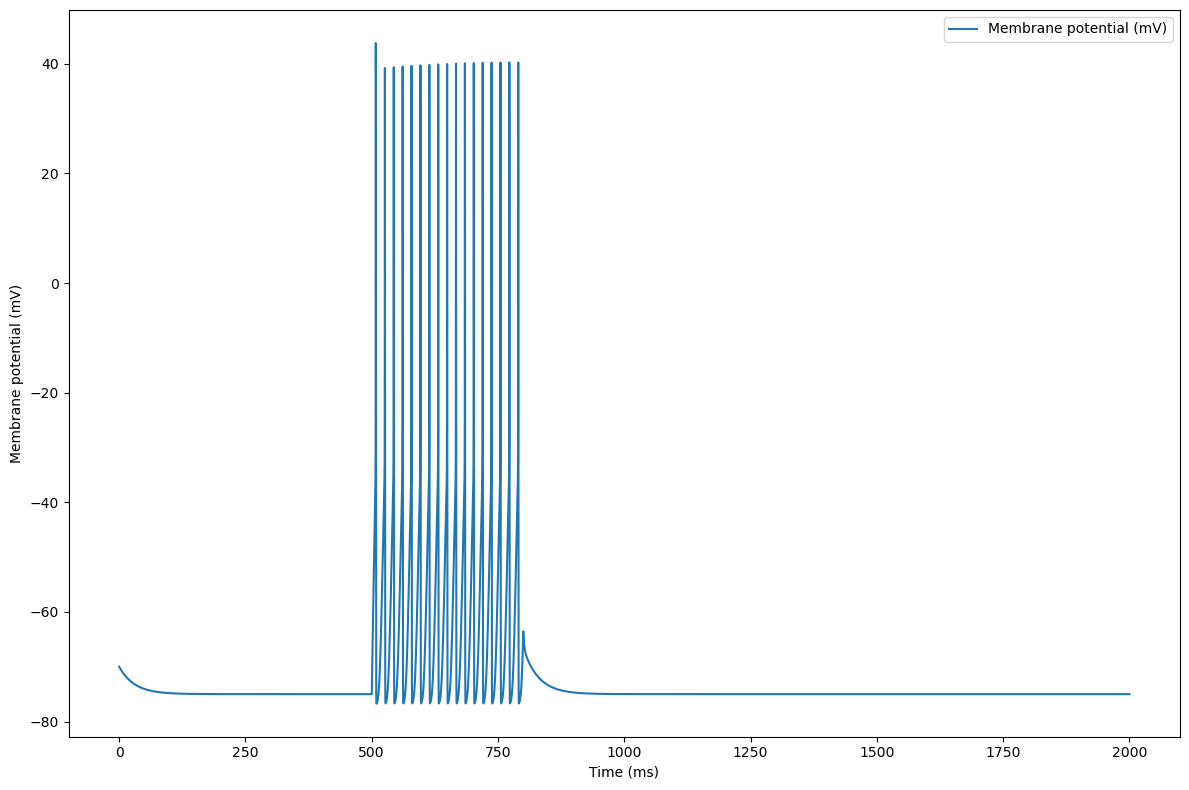

In [ ]:
h.dt = 0.1  # time step (resolution) of the simulation in ms
h.tstop = 2000  # how long to run the simulation in ms
h.v_init = -70  # initial membrane potential in mV

# Create soma section
soma = h.Section(name="soma")
soma.L = 50 # soma length um
soma.diam = 50 # soma diameter um
soma.cm = 1 # membrane capacitance uF/cm2
soma.Ra = 30 # ohm-cm

# Vectors for recording
t = h.Vector()
soma_v = h.Vector()
i = h.Vector()
t.record(h._ref_t)
soma_v.record(soma(0.5)._ref_v)

# List to keep track of inserted mechanisms
inserted_mechanisms = []

# Function to insert mechanism into soma
def insert_mechanism(mech):
    soma.insert(mech)
    inserted_mechanisms.append(mech)

# Function to reset the simulation
def reset_simulation():
    # Clear inserted mechanisms
    for mech in inserted_mechanisms:
        soma.uninsert(mech)
    inserted_mechanisms.clear()
    # Reset the simulation vectors
    t.resize(0)
    soma_v.resize(0)

# Folder containing mod files
mod_folder_path = "./"

# List all mod files in the folder
mod_files = [f[:-4] for f in os.listdir(mod_folder_path) if f.endswith(".mod")]

# Dropdown widget for selecting mod files
mod_dropdown = widgets.Dropdown(
    options=mod_files,
    value=mod_files[0],
    description='Select Mod File:',
)

# Label to display inserted mechanisms
inserted_label = widgets.Label(value="Inserted Mechanisms: ")

# Button to insert selected mod file
insert_button = widgets.Button(description='Insert Mod File')

# Function to handle mod file insertion
def on_insert_button_click(b):
    selected_mod_file = mod_dropdown.value
    insert_mechanism(selected_mod_file)
    # Update the label to display inserted mechanisms
    inserted_label.value = "Inserted Mechanisms: " + ", ".join(inserted_mechanisms)

insert_button.on_click(on_insert_button_click)

reset_button = widgets.Button(description='Reset Simulation')

# Function to handle reset button click
def on_reset_button_click(b):
    reset_simulation()
    inserted_label.value = "Inserted Mechanisms: (none)"

reset_button.on_click(on_reset_button_click)

# Slider widgets for setting IClamp parameters
amp_slider = widgets.FloatSlider(value=0.1, min=0.1, max=1.0, step=0.05, description='Amplitude (nA):')
dur_slider = widgets.IntSlider(value=300, min=100, max=500, step=50, description='Duration (ms):')
delay_slider = widgets.IntSlider(value=500, min=0, max=1000, step=100, description='Delay (ms):')

# Button to run the simulation
run_button = widgets.Button(description='Run Simulation')

# Function to handle simulation run
def on_run_button_click(b):
    clear_output()
    display(VBox([HBox([VBox([mod_dropdown, inserted_label]), VBox([amp_slider, dur_slider, delay_slider])]),HBox([insert_button, reset_button,run_button])]))
    iclamp.amp = amp_slider.value
    iclamp.dur = dur_slider.value
    iclamp.delay = delay_slider.value
    h.finitialize(h.v_init * mV)  # runs sims
    h.continuerun(h.tstop * ms)
    # Display the plot
    plot_results()

run_button.on_click(on_run_button_click)

# Display widgets
display(VBox([HBox([VBox([mod_dropdown, inserted_label]), VBox([amp_slider, dur_slider, delay_slider])]),HBox([insert_button, reset_button,run_button])]))

# Create IClamp
iclamp = h.IClamp(soma(0.5))

# Plotting
def plot_results():
    plt.figure(figsize=(12, 8))

    # Plot membrane potential
    plt.plot(t, soma_v, label='Membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane potential (mV)')
    plt.legend()

    plt.tight_layout()
    plt.show()

